In [1]:
import pandas as pd
import numpy as np
import altair as alt

import pymc as pm
import arviz as az

data = pd.read_csv('./data/discrimination.csv', index_col=0)

data.head()


,gender,age,ethnicity,party,conservative,discrimination
0,male,36,estonian,Keskerakond,1,0
1,female,50,estonian,SDE,0,0
2,male,67,estonian,Isamaa,1,0
3,male,58,estonian,Reform,0,0
4,male,62,estonian,Reform,1,0


In [2]:
data.groupby('discrimination').conservative.value_counts(normalize=True)

discrimination  conservative
0               1               0.518341
                0               0.481659
1               1               0.774799
                0               0.225201
Name: proportion, dtype: float64

In [3]:

alt.Chart(data.replace({0: 'No', 1: 'Yes'}), width=300).mark_bar().encode(
    x='conservative:N',
    xOffset='discrimination:N',
    y='count()',
    color='discrimination:N'
)

alt.Chart(...)

In [5]:
### Let's code the model

coords = {"predictors": ["conservative"]}

with pm.Model(coords=coords) as model:
    alpha = pm.Normal("alpha", mu=0, sigma=10)
    beta_conservative = pm.Normal("beta_conservative", mu=0, sigma=10)
    
    p = pm.math.sigmoid(alpha + beta_conservative * data["conservative"])
    likelihood = pm.Bernoulli("discrimination", p=p, observed=data["discrimination"])
    
    trace = pm.sample()

print("NModel summary:")
pm.summary(trace)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta_conservative]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


NModel summary:


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,-1.280,0.086,-1.442,-1.127,0.003,0.002,890.0,1485.0,1.01
beta_conservative,1.162,0.103,0.968,1.352,0.003,0.002,920.0,1556.0,1.01


In [18]:
import pymc_extras as pmx

with pm.Model(coords=coords) as model:
    alpha = pm.Normal("alpha", mu=0, sigma=10)
    beta_conservative = pm.Normal("beta_conservative", mu=0, sigma=10)
    
    p = pm.math.sigmoid(alpha + beta_conservative * data["conservative"])
    likelihood = pm.Bernoulli("discrimination", p=p, observed=data["discrimination"])

    t_path = pmx.fit(
        method="pathfinder",
        jitter=12,
        num_draws=1000,
        random_seed=123,
    )
    
    #t2 = pm.fit()



Output()

Pathfinder Results                         
                                           
  No. model parameters     2               
                                           
  Configuration:                           
  num_draws_per_path       1000            
  history size (maxcor)    5               
  max iterations           1000            
  ftol                     1.00e-05        
  gtol                     1.00e-08        
  max line search          1000            
  jitter                   12              
  epsilon                  1.00e-08        
  ELBO draws               10              
                                           
  LBFGS Status:                            
  CONVERGED                4               
  L-BFGS iterations        mean 9 ± std 1  
                                           
  Path Status:                             
  SUCCESS                  4               
  ELBO argmax              mean 6 ± std 2  
                                           
  Importance Sampling:                     
  Method                   psis            
  Pareto k                 0.73            
                                           
  Timing (seconds):                        
  Compile                  4.77            
  Compute                  0.29            
  Total                    5.06

In [23]:
pm.summary(t_path)

arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,-1.280,0.073,-1.413,-1.139,0.002,0.002,1020.0,983.0,NaN
beta_conservative,1.161,0.065,1.042,1.276,0.002,0.002,957.0,608.0,NaN


array([<Axes: title={'center': 'alpha'}>,
       <Axes: title={'center': 'beta_conservative'}>], dtype=object)

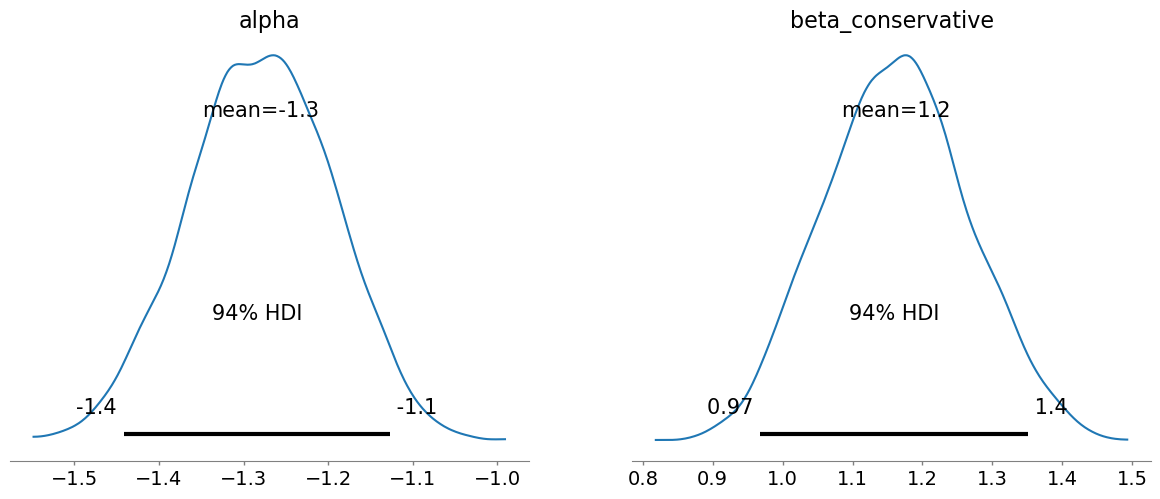

In [20]:
trace2 = t2.sample(draws=1000)

pm.plot_posterior(trace)


In [14]:
### Same with plain regression model

import statsmodels.api as sm
import statsmodels.formula.api as smf

# Define the logistic regression formula
formula = 'discrimination ~ conservative'

# Fit the logistic regression model
model = smf.logit(formula=formula, data=data)
results = model.fit()

# Print the summary of the model
print(results.summary())

Optimization terminated successfully.
         Current function value: 0.626752
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:         discrimination   No. Observations:                 2000
Model:                          Logit   Df Residuals:                     1998
Method:                           MLE   Df Model:                            1
Date:                Thu, 13 Mar 2025   Pseudo R-squ.:                 0.05114
Time:                        21:43:48   Log-Likelihood:                -1253.5
converged:                       True   LL-Null:                       -1321.1
Covariance Type:            nonrobust   LLR p-value:                 3.102e-31
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -1.2796      0.087    -14.670      0.000      -1.451      -1.109
conservative     1.1622

In [3]:
### Model stratified by party preference

# Add party preference as dummy variables
party_dummies = pd.get_dummies(data["party"], drop_first=True).astype(int)
df = pd.concat([data, party_dummies], axis=1)

# Add dummies to predictors
coords["predictors"] = ["conservative"] + list(party_dummies.columns)

with pm.Model(coords=coords) as adjusted_model:
    alpha = pm.Normal("alpha", mu=0, sigma=10)
    beta = pm.Normal("beta", mu=0, sigma=10, dims="predictors")
    
    predictors = df[["conservative"] + list(party_dummies.columns)]
    p = pm.math.sigmoid(alpha + pm.math.dot(predictors, beta))
    likelihood = pm.Bernoulli("discrimination", p=p, observed=df["discrimination"])
    
    party_adjusted_trace = pm.sample()
    
pm.summary(party_adjusted_trace)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,-1.631,0.286,-2.177,-1.100,0.010,0.007,768.0,1218.0,1.0
beta[conservative],0.083,0.162,-0.212,0.398,0.004,0.003,1606.0,2093.0,1.0
beta[EKRE],2.752,0.340,2.104,3.367,0.012,0.008,812.0,1216.0,1.0
beta[Isamaa],0.525,0.327,-0.076,1.149,0.012,0.007,768.0,1219.0,1.0
beta[Keskerakond],2.144,0.335,1.548,2.805,0.012,0.007,805.0,1258.0,1.0
beta[Parempoolsed],-0.127,0.394,-0.848,0.645,0.012,0.008,1061.0,1672.0,1.0
beta[Reform],0.003,0.325,-0.587,0.617,0.011,0.007,812.0,1218.0,1.0
beta[SDE],-0.135,0.334,-0.767,0.490,0.011,0.007,860.0,1482.0,1.0


In [4]:
### Kitchen sink model

# Add party preference as dummy variables
party_dummies = pd.get_dummies(data["party"], drop_first=True).astype(int)
df = pd.concat([data, party_dummies], axis=1)

# Convert ethnicity and gender values to 0 and 1
df.replace({'male': 1, 'female': 0, 'estonian': 1, 'other':0}, inplace=True)

# Scale the age column and add it to predictors together with gender and ethnicity
df["age_scaled"] = (df["age"] - df["age"].mean()) / df["age"].std()
coords["predictors"] = ["conservative", "age_scaled", "gender", "ethnicity"] + list(party_dummies.columns)

with pm.Model(coords=coords) as adjusted_model:
    alpha = pm.Normal("alpha", mu=0, sigma=10)
    beta = pm.Normal("beta", mu=0, sigma=10, dims="predictors")
    
    predictors = df[["conservative", "age_scaled", "gender", "ethnicity"] + list(party_dummies.columns)]
    p = pm.math.sigmoid(alpha + pm.math.dot(predictors, beta))
    likelihood = pm.Bernoulli("discrimination", p=p, observed=df["discrimination"])
    
    kitchen_sink_trace = pm.sample()
    
pm.summary(kitchen_sink_trace)

/var/folders/2z/7k7z_91s1y50t4lpv5jlllpm0000gn/T/ipykernel_29613/3285172753.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.replace({'male': 1, 'female': 0, 'estonian': 1, 'other':0}, inplace=True)
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,-1.663,0.352,-2.356,-1.034,0.010,0.007,1313.0,1735.0,1.0
beta[conservative],0.081,0.166,-0.214,0.402,0.003,0.003,2920.0,2570.0,1.0
beta[age_scaled],-0.055,0.055,-0.162,0.043,0.001,0.001,3544.0,2670.0,1.0
beta[gender],0.054,0.110,-0.169,0.246,0.002,0.002,3543.0,2533.0,1.0
beta[ethnicity],-0.021,0.175,-0.348,0.296,0.003,0.003,3131.0,2605.0,1.0
beta[EKRE],2.778,0.358,2.144,3.484,0.010,0.007,1239.0,1766.0,1.0
beta[Isamaa],0.548,0.345,-0.083,1.214,0.010,0.007,1203.0,1719.0,1.0
beta[Keskerakond],2.164,0.363,1.485,2.838,0.011,0.007,1181.0,1748.0,1.0
beta[Parempoolsed],-0.107,0.407,-0.879,0.663,0.010,0.007,1529.0,2081.0,1.0
beta[Reform],0.025,0.341,-0.627,0.667,0.009,0.006,1341.0,1877.0,1.0


In [23]:

# Define the kitchen sink regression formula
formula = 'discrimination ~ conservative + ethnicity + gender + party'

# Fit the logistic regression model
model = smf.logit(formula=formula, data=data)
results = model.fit()

# Print the summary of the model
print(results.summary())

Optimization terminated successfully.
         Current function value: 0.527911
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:         discrimination   No. Observations:                 2000
Model:                          Logit   Df Residuals:                     1990
Method:                           MLE   Df Model:                            9
Date:                Thu, 13 Mar 2025   Pseudo R-squ.:                  0.2008
Time:                        21:46:03   Log-Likelihood:                -1055.8
converged:                       True   LL-Null:                       -1321.1
Covariance Type:            nonrobust   LLR p-value:                1.695e-108
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                -1.6479      0.302     -5.465      0.000      -2.239      -1.